<a href="https://colab.research.google.com/github/kelvincrdz/Detecot-de-objetos-no-Youtube/blob/main/notebooks/youtube_Video_obj_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/amdegroot/ssd.pytorch.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
    # clonar e instalar dependências
    !git clone -q $git_repo_url
    !pip install -q youtube-dl
    !wget https://raw.githubusercontent.com/kelvincrdz/Detecot-de-objetos-no-Youtube/main/detection.py && mv detection.py ssd.pytorch/layers/functions
    !wget https://raw.githubusercontent.com/kelvincrdz/Detecot-de-objetos-no-Youtube/main/ssd.py && mv ssd.py ssd.pytorch/
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

## Download o SSD300 modelo pre treinado

In [11]:

PRETRAINED_MODEL_URL = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'
pretrained_model = basename(PRETRAINED_MODEL_URL)
if not exists(pretrained_model):
  !wget -q $PRETRAINED_MODEL_URL


## Preparando modelo

In [ ]:

!sed -i 's/HOME = os.path.expanduser("~")/HOME = "$project_name"/' $project_name/data/config.py
!sed -i "s/COCO_ROOT = osp.join(HOME, 'data\/coco\/')/COCO_ROOT = '$project_name\/data'/" $project_name/data/coco.py
!sed -i 's/if scores.dim() == 0/if scores.size(0) == 0/' $project_name/layers/functions/detection.py

import random
import cv2
import numpy as np
import torch

from ssd import build_ssd
from data import VOC_CLASSES as labels
colors = [[random.randint(0, 255) for _ in range(3)] for _ in labels]

# build SS model
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights(pretrained_model)
net.eval()
torch.set_grad_enabled(False)

if torch.cuda.is_available():
  net = net.cuda()

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


def test(rgb_image, threshold=0.6):
  x = cv2.resize(rgb_image, (300, 300)).astype(np.float32)
  x -= (123.0, 117.0, 104.0)
  x = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1)
  x = x.unsqueeze(0)
  if torch.cuda.is_available():
    x = x.cuda()
  
  t = time.time()
  detections = net(x)
  
  # draw boxes and labels
  result_img = np.array(rgb_image)
  scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
  for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= threshold:
      score = detections[0,i,j,0]
      label = labels[i-1]
      display_txt = '%s: %.2f'%(label, score)
      pt = (detections[0,i,j,1:]*scale).cpu().numpy()
      color = colors[i-1]

      # draw box
      tl = round(0.002 * max(result_img.shape[0:2])) + 1  # line thickness
      c1, c2 = (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3]))
      cv2.rectangle(result_img, c1, c2, color, thickness=tl)

      # draw text
      tf = max(tl - 1, 1)  # font thickness
      t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
      c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
      cv2.rectangle(result_img, c1, c2, color, -1)  # filled
      cv2.putText(result_img, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

      j+=1
      
  return result_img

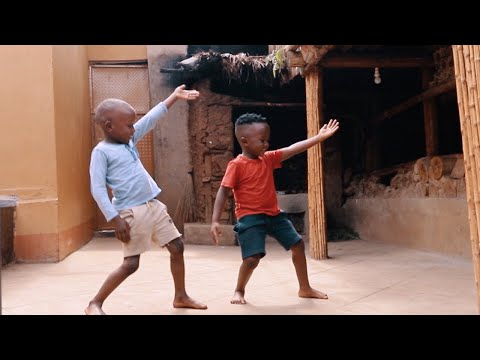

In [13]:
YOUTUBE_ID = 'TH4V-yHbJXk'

YouTubeVideo(YOUTUBE_ID)

Primeiro, baixe o vídeo do youtube acima:



In [ ]:
!rm -df youtube.mp4

!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# faça a detecção de objetos apenas nos primeiros 20 segundos...
!ffmpeg -y -loglevel info -i youtube.mp4 -t 20 video.mp4

[download] 100% of 43.31MiB in 10:51
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-

Agora detecte objetos no vídeo baixado:

In [ ]:
video_capture = cv2.VideoCapture()
if video_capture.open('video.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  !rm -f output.mp4 output.avi
  # não pode escrever mp4, então tente escrever em um arquivo AVI
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
      
    start = time.time()
    
    rgb_frame = test(frame[:,:,::-1])
    frame = rgb_frame[:,:,::-1]

    end = time.time()
    print("time: {}s, fps: {}".format(end-start, 1/(end-start)))
            
    video_writer.write(frame)
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("não é possível abrir o arquivo de vídeo de entrada fornecido!")

Mostre o vídeo do resultado:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)